## Importing Libraries

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import joblib

from wordcloud import WordCloud
from collections import Counter

# Data Proprocessing

## Loading Data

Load the data, and have an overview of the data

In [2]:
data = pd.read_csv('Suicide_Detection.csv')

print(data.head(),"\n")
print(data.info(),"\n")
print("Shape: ",data.shape)

# Convert string to 0/1 values
data['is_suicide'] = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
None 

Shape:  (232074, 3)


The column 'Unnammed: 0' is a meaningless column at here, thus we can delete it

In [3]:
data.drop(columns = 'Unnamed: 0', inplace=True)
data.head()

,text,class,is_suicide
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1
1,Am I weird I don't get affected by compliments...,non-suicide,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1


Check is null value available

In [4]:
data.isnull().sum()

text          0
class         0
is_suicide    0
dtype: int64

### Features Engineering

In [5]:
data['total_words'] = data['text'].apply(lambda x: len(x.split()))
data.head()

,text,class,is_suicide,total_words
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143
1,Am I weird I don't get affected by compliments...,non-suicide,0,27
2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26
3,i need helpjust help me im crying so hard,suicide,1,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438


## Data Visualization

Proportion of suicide and non-suicide thoughts

1    116037
0    116037
Name: is_suicide, dtype: int64


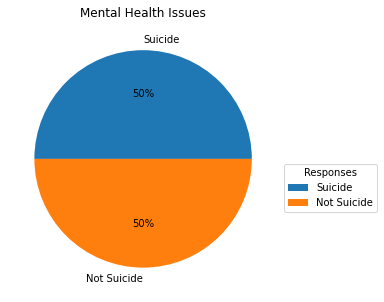

In [6]:
classCount = data["is_suicide"].value_counts()
print(classCount)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
plt.title('Mental Health Issues')
plt.pie(classCount, labels=['Suicide', 'Not Suicide'], autopct='%.0f%%')

# Add a legend outside the pie chart
plt.legend(title="Responses", loc="upper left", bbox_to_anchor=(1, 0.5))

# Add a legend outside the pie chart

plt.show()

## Text Processing

Lower Case, Remove Puncutuations, Remove Stop Words

In [7]:
# Convert texts to lower case
data['preprocessed_text'] = data['text'].str.lower()

# Remove punctuations
data['preprocessed_text'] = data['preprocessed_text'].str.replace(r'[^\w\s]+','',regex=True)

# Remove stop words
stop_words = stopwords.words('english')
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenize the words
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x:nltk.word_tokenize(x))

### Lemmatization

In [8]:
# Lemmatize the words
lemmatizer = WordNetLemmatizer()
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: [lemmatizer.lemmatize(word,pos='v') for word in x])

# ps = PorterStemmer()
# data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: [ps.stem(i) for i in x])

# Combine the words
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: ' '.join(x))

data.head()

,text,class,is_suicide,total_words,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143,ex wife threaten suiciderecently leave wife go...
1,Am I weird I don't get affected by compliments...,non-suicide,0,27,weird dont get affect compliment come someone ...
2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26,finally 2020 almost never hear 2020 bad year e...
3,i need helpjust help me im crying so hard,suicide,1,9,need helpjust help im cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438,im losthello name adam 16 ive struggle years i...


Check null values after preprocessing process

In [9]:
data.isnull().sum()

text                 0
class                0
is_suicide           0
total_words          0
preprocessed_text    0
dtype: int64

Save preprocessed works to new csv file

In [10]:
data['preprocessed_text'] = data['preprocessed_text'].astype(str)
data.to_csv('preprocessed.csv')

In [2]:
preprocessed_data = pd.read_csv('preprocessed.csv')
preprocessed_data.dropna(inplace=True)
preprocessed_data.head()

,Unnamed: 0,text,class,is_suicide,total_words,preprocessed_text
0,0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143,ex wife threaten suiciderecently leave wife go...
1,1,Am I weird I don't get affected by compliments...,non-suicide,0,27,weird dont get affect compliment come someone ...
2,2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26,finally 2020 almost never hear 2020 bad year e...
3,3,i need helpjust help me im crying so hard,suicide,1,9,need helpjust help im cry hard
4,4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438,im losthello name adam 16 ive struggle years i...


### Words Frequency

show words commonly used when expressing suicidal thought

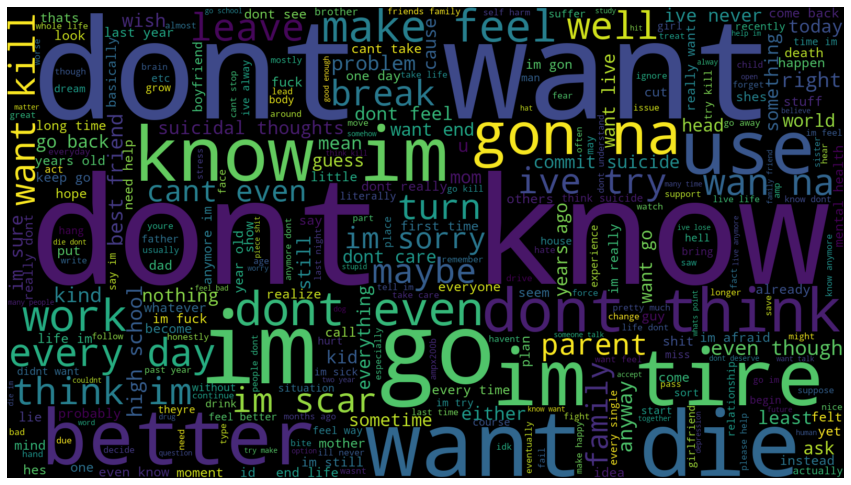

In [12]:
# Generate word cloud of suicidal thoughts
preprocessed_data['preprocessed_text'] = preprocessed_data['preprocessed_text'].astype(str)

suicidal_thoughts = " ".join(preprocessed_data[preprocessed_data['is_suicide'] == 1]['preprocessed_text'])

plt.figure(figsize=(15,10))
wordcloud = WordCloud(max_words = 300, height = 900, width = 1600, background_color='black',colormap='viridis').generate(suicidal_thoughts)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

show words ranking of suicidal thought

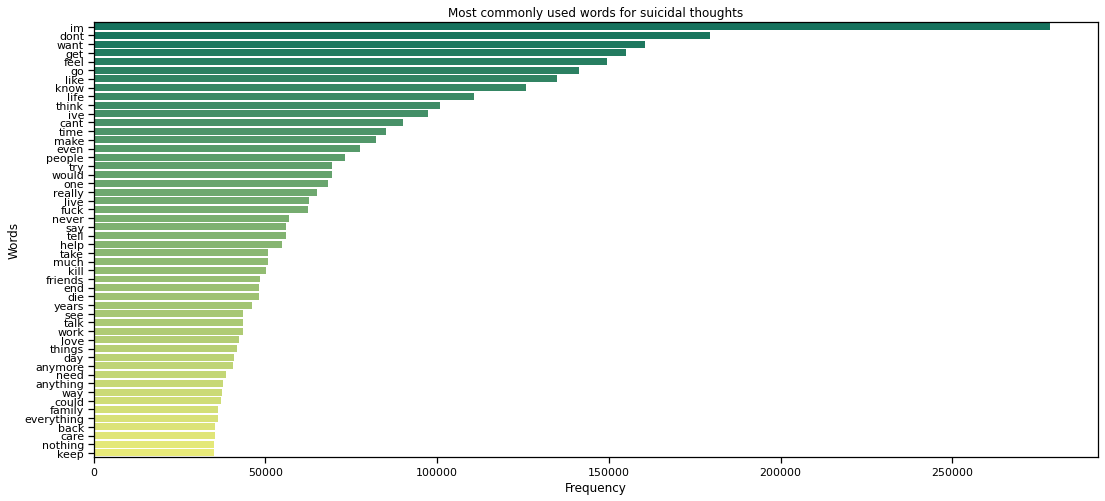

In [13]:
depression_words_ranking = []
for sentence in preprocessed_data[preprocessed_data['is_suicide'] == 1]['preprocessed_text'].to_list():
    for word in sentence.split():
        depression_words_ranking.append(word)
        
df = pd.DataFrame(Counter(depression_words_ranking).most_common(50),columns=['Word','Frequency'])

sns.set_context('notebook')
plt.figure(figsize=(18,8))
sns.barplot(y=df['Word'], x=df['Frequency'],palette='summer')
plt.title('Most commonly used words for suicidal thoughts')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Comparions of Original word & Preprocessed word

In [13]:
preprocessed_data[['text','preprocessed_text']]

Unnamed: 0            0
text                  0
class                 0
is_suicide            0
total_words           0
preprocessed_text    32
dtype: int64


## Split Data

For training the dataset and make predictions

In [4]:
x,y = preprocessed_data['preprocessed_text'],preprocessed_data['is_suicide']

vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x = vectorizer.fit_transform(x).toarray()

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=3)
X_train.shape, X_test.shape

((185633, 5000), (46409, 5000))

# Models

## Naive Bayes

Naive bayes with voting classifier

In [25]:
naive_bayes_gaussian = GaussianNB()
naive_bayes_bernoulli = BernoulliNB()
naive_bayes_multinomial = MultinomialNB()

nb_classifier = VotingClassifier(
    estimators=[
        ('GaussianNB',naive_bayes_gaussian),
        ('Bernoulli',naive_bayes_bernoulli),
        ('Multinomial',naive_bayes_multinomial)
    ],voting='soft',verbose=1
)

VotingClassifiers.fit(X_train,y_train)

nb_prediction = nb_classifier.predict(X_test)
nb_confusion_matrix = confusion_matrix(y_test,nb_prediction)
nb_accuracy = accuracy_score(y_test,nb_prediction)

# Score for Training
print("Training Score = ",nb_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",nb_classifier.score(X_test,y_test))

# Confusion Matrix
print("\n\nConfusion Matrix : ", nb_confusion_matrix)

print(classification_report(y_test,nb_prediction))

[Voting] ............... (1 of 3) Processing GaussianNB, total=  19.9s
[Voting] ................ (2 of 3) Processing Bernoulli, total=  18.0s
[Voting] .............. (3 of 3) Processing Multinomial, total=   3.0s
Training Score =  0.9031907042390093
Testing Score =  0.9000409403348488


Confusion Matrix :  [[20758  2506]
 [ 2133 21012]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     23264
           1       0.89      0.91      0.90     23145

    accuracy                           0.90     46409
   macro avg       0.90      0.90      0.90     46409
weighted avg       0.90      0.90      0.90     46409



## Logistic Regression

In [5]:
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train,y_train)

lr_prediction = lr_classifier.predict(X_test)
lr_confusion_matrix = confusion_matrix(y_test,lr_prediction)
lr_accuracy = accuracy_score(y_test,lr_prediction)

# Score for Training
print("Training Score = ",lr_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",lr_classifier.score(X_test,y_test))

# Confusion Matrix
print("\nConfusion Matrix : ", lr_confusion_matrix)

print(classification_report(y_test,lr_prediction))

Training Score =  0.9384915397585558
Testing Score =  0.9335904673662436

Confusion Matrix :  [[21956  1308]
 [ 1774 21371]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     23264
           1       0.94      0.92      0.93     23145

    accuracy                           0.93     46409
   macro avg       0.93      0.93      0.93     46409
weighted avg       0.93      0.93      0.93     46409



## Random Forest

In [28]:
%time

# random_forest_classifier = RandomizedSearchCV(
#     RandomForestClassifier(),
#     {
#         'n_estimators':[4,5],
#         'criterion':['entropy'],
#         'max_depth':range(1,4),'min_samples_split':range(2,5)
#     }, random_state=10
# )

random_forest_classifier = RandomForestClassifier(n_estimators=40,random_state=20,verbose=1)

random_forest_classifier.fit(X_train,y_train)

rf_prediction = random_forest_classifier.predict(X_test)
rf_confusion_matrix = confusion_matrix(y_test,rf_prediction)
rf_accuracy = accuracy_score(y_test,rf_prediction)

# Score for Training
print("Training Score = ",random_forest_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",random_forest_classifier.score(X_test,y_test))

# Confusion Matrix
print("\nConfusion Matrix : ", rf_confusion_matrix)

print(classification_report(y_test,rf_prediction))

CPU times: total: 0 ns
Wall time: 0 ns


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  8.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    5.4s finished


Training Score =  0.998109172399304


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Testing Score =  0.8982524941282941

Confusion Matrix :  [[20812  2452]
 [ 2270 20875]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     23264
           1       0.89      0.90      0.90     23145

    accuracy                           0.90     46409
   macro avg       0.90      0.90      0.90     46409
weighted avg       0.90      0.90      0.90     46409



[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.2s finished


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize base classifier (Random Forest)
base_classifier = RandomForestClassifier(n_estimators=30, random_state=10)

# Initialize AdaBoostClassifier with Random Forest as the base estimator
adaboost_classifier = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=50, random_state=10)

# Train the AdaBoostClassifier
adaboost_classifier.fit(X_train, y_train)

# Predictions
adaboost_predictions = adaboost_classifier.predict(X_test)

# Evaluate
adaboost_accuracy = accuracy_score(y_test, adaboost_predictions)
print("AdaBoost Classifier Accuracy:", adaboost_accuracy)


## Support Vector Machines (SVM)

In [ ]:
svm_classifier = SVC(kernel='linear')

svm_classifier.fit(X_train,y_train)

svm_prediction = svm_classifier.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_test,svm_prediction)
svm_accuracy = accuracy_score(y_test,svm_prediction)

# Score for Training
print("Training Score = ",svm_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",svm_classifier.score(X_test,y_test))

# Confusion Matrix
print("\nConfusion Matrix : ", svm_confusion_matrix)

print(classification_report(y_test,svm_prediction))

In [ ]:
# Reduced Data Size

# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

# Reduce the size of the training data to 10%
sample_size = int(0.10 * len(X_train_full))
X_train_sample = X_train_full.sample(n=sample_size, random_state=3)
y_train_sample = y_train_full.loc[X_train_sample.index]

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier on the sampled data
svm_classifier.fit(X_train_sample, y_train_sample)

# Predictions
svm_prediction = svm_classifier.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_test, svm_prediction)
svm_accuracy = accuracy_score(y_test, svm_prediction)

# Score for Training
print("Training Score = ", svm_classifier.score(X_train_sample, y_train_sample))

# Score for Testing
print("Testing Score = ", svm_accuracy)

# Confusion Matrix
print("\nConfusion Matrix : ", svm_confusion_matrix)

print(classification_report(y_test, svm_prediction))

## Decision Tree

In [ ]:
%time

decision_tree_classifier = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=200,max_depth=9,random_state=2)
decision_tree_classifier.fit(X_train,y_train)

dt_prediction = decision_tree_classifier.predict(X_test)
dt_confusion_matrix = confusion_matrix(y_test,dt_prediction)
dt_accuracy = accuracy_score(y_test,dt_prediction)
                             
# Score for Training
print("Training Score = ",decision_tree_classifier.score(X_train,y_train))
                             
# Score for Testing
print("Testing Score = ",decision_tree_classifier.score(X_test,y_test))

# Confusion Matrix
print("\nConfusion Matrix : ", dt_confusion_matrix)

print(classification_report(y_test,dt_prediction))

# Conclusion

In [ ]:
model_ev = pd.DataFrame({
    'Model':['Naive Bayes','Random Forest','Decision Tree','Logistic Regression'],
    'Accuracy':[nb_accuracy,nb_accuracy,lr_accuracy]
})

model_ev

Naive Bayes is the best fit model for the given dataset as it has the values,
- Training Score: 0.9024567408018418
- Testing Score =  0.8993723338551916

### Save Model

Save the model (Naive Bayes )with highest accuracy to a joblib file

In [6]:
joblib.dump(VotingClassifiers,'naive_bayes_model.joblib')
joblib.dump(lr_classifier,'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

In [78]:
logistic_regression_model = joblib.load('logistic_regression_model.joblib')
naive_bayes_model = joblib.load('naive_bayes_model.joblib')

# def preprocess(text):
#     # Lowercase the word
#     text = text.lower()
    
#     # Remove punctuation
#     text = text.replace(r'[^\w\s]+','')
    
#     # Lemmatize the word
#     lemmatizer = WordNetLemmatizer()
#     stop_words = stopwords.words('english')
    
#     processed_tokens = [lemmatizer.lemmatize(word, pos='v') for word in word_tokenize(text) if word not in stop_words]
    
#     return ' '.join(processed_tokens)

# def mental_health_issue_detector(text):
#     print("Input = ", text)
#     processed_text = preprocess(text)
#     prediction = logistic_regression_model.predict([processed_text])  # Wrap processed_text in a list to make it a 2D array
#     print(prediction[0])

def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    
    text = text.lower()
    text = text.replace(r'[^\w\s]+','')
#     text = [text for text in text.split() if text not in (stop_words)]
#     print(text)
    word = ' '.join([lemmatizer.lemmatize(i, pos='v') for i in word_tokenize(text) if i not in stop_words])
    return vectorizer.transform([word]).toarray()

def mental_health_issue_detector(text):
    print("Input = ",text)
    processed_word = preprocess(text)
    prediction = naive_bayes_model.predict(processed_word)
    print(prediction[0])

## User Input

In [92]:
mental_health_issue_detector("""
    We are excited to inform you about an upcoming industrial talk presented by Beijing Deep Glint Technology Co., Ltd., a prominent AI company from China. This event is scheduled for 22nd March 2024 (Friday), from 10:00 am to 11:00 am, and will take place in DK4. We kindly ask all attendees to arrive 15 minutes early, by 9:45 am, to ensure a timely start. Immediately following the conclusion of the talk at 11:00 am, our regular AI class will resume and continue until 12:00 pm. Attendance at this talk is mandatory and will be documented. Please find attached additional information about the talk's subject and the biography of the speaker.
""")

Input =  
    We are excited to inform you about an upcoming industrial talk presented by Beijing Deep Glint Technology Co., Ltd., a prominent AI company from China. This event is scheduled for 22nd March 2024 (Friday), from 10:00 am to 11:00 am, and will take place in DK4. We kindly ask all attendees to arrive 15 minutes early, by 9:45 am, to ensure a timely start. Immediately following the conclusion of the talk at 11:00 am, our regular AI class will resume and continue until 12:00 pm. Attendance at this talk is mandatory and will be documented. Please find attached additional information about the talk's subject and the biography of the speaker.

0
